## Alignment of batch 8 outliers to ACod


#### batch 8 verif


<br>

In this notebook, I align outlier loci to the Atlantic cod genome and then explore annotations. I will be aligning *all* outlier loci that were identified in either OutFlank or Bayescan (with priors of 100,1000, and 10K).
<br>

This includes the following steps:
1. Create bowtie reference database of gadMor2
2. Create fasta file of outlier loci (using consensus sequences from stacks)
3. Align fasta to the genome with bowtie2
4. Filter alignment by mapping quality (cutoff MQ > 10)
5. Use `closestBed` to find the closest annotated feature in Atlantic cod to each aligned locus.





<br>

Programs used: `bowtie2`, `samtools`, `bedtools`
<br>
(see notes on installation of each of these programs [here](https://github.com/mfisher5/PCod-Korea-repo/blob/master/notebooks/Batch%208%20-%20Outlier%20Alignment.ipynb))


<br>
** I started with 57 outlier loci. 43 of these aligned uniquely with a mapping quality > 10.**


<br>
<br>
#### 3/15/2018

<br>
### 1. Create reference database of (new) Atlantic cod genome

Completed previously.See notebook [Alignment of batch 8 outliers to ACod, eastern PCod](https://github.com/mfisher5/PCod-Korea-repo/blob/master/notebooks/Batch%208%20-%20Outlier%20Alignment.ipynb)
<br>
The [gadMor2](https://osf.io/4qsdw/) was published by [Torresen et al. 2017 in BMC Genomics](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-3448-x) (open access).

<br>

### 2. Create fasta file of outlier loci consensus sequences

I can do this by going into the `batch_8.catalog.tags.tsv` file and extracting the consensus sequence associated with each outlier locus ID. 

In [1]:
cd ../

/mnt/hgfs/PCod-Korea-repo


First, read in a list of outlier loci (one locus per line, text file).

In [3]:
###################### objects ###############################
myfile = "analyses/Outliers/batch8_verif/batch_8_outliers_to_align.txt" # list of outlier loci
###############################################################


# read in outlier loci IDs
infile = open(myfile, "r")

outlier_list = []
for line in infile:
    outlier_list.append(line.strip())
infile.close()

Then match those loci to sequences in the stacks catalog.tags.tsv file

In [4]:
###################### objects ###############################
catalog = "stacks_b8_verif/batch_7.catalog.tags.tsv"
newfile = "analyses/Outliers/batch8_verif/batch_8_verif_outliers.fa" # parsed output from this script
###############################################################


# write out the locus IDs and the consensus sequences to a new fasta file
seqfile = open(catalog, "r")
outfile = open(newfile, "w")
seqs_added = 0
seqfile.readline()
for line in seqfile:
    linelist = line.strip().split("\t")
    if linelist[2] in outlier_list:
        outfile.write(">" + linelist[2] + "\n" + linelist[9] + "\n")
        seqs_added += 1
seqfile.close()
outfile.close()
print "Succesfully added sequences for ", seqs_added, " outlier loci."

Succesfully added sequences for  57  outlier loci.


In [5]:
!head analyses/Outliers/batch8_verif/batch_8_verif_outliers.fa

>74
TGCAGGAGCAGGAGAGGATCATCACCATGTCGTATGCACTGGCTTCCGAGGCGTCGCTTAAGAGCAAACAGGTCACAGGTACGTCCGCTCGTCTGTTCAACCATCTGCTCCAGCTCACTTCTCAAAGACTCCTTCTCTTTAG
>453
TGCAGGTGCACCTCCGACCCCTTCTCATAGGCCTCCCAGGCGAACACTGGAACACAGCGCACGGCCGGGCCGTTAACCAGGGGCACCACGCACACACTGCAGGGCTGGGGTTAACTAGCTACTACTGGTTAGAGACTTAGGT
>1904
TGCAGGAAAATATAAATACAGTACGCAAAAAATTACTTCGACGGAAAGTCCTCAGATTGTGCTTCAGCTTCAGATGCCATCAAGAGGGGTCTCTGGTCGTAATCAGTCGCAAGTTCGTCCCTGACCAATCAGCATTCATTAG
>2098
TGCAGGATGTCAGCTTGCTGATGTAAAAACCCATGTGGTGTTCCCATTTCAGAGACCTGTTGGTGAACTCTCTCTTGTAAATTCAACAGCCAGAAGATGCAATCGATGCTTGTGTGACATAGAAAATAGTCTTGACATACTG
>2606
TGCAGGATCAACCTCTCAGGAGCCAAACCAACAGCCGTCCCGAGACATCGGGCGGGTGGTGCACCATCCCGTGGGCCTGTGGAAGTGCATCCGGCCTGAACGGTACCGGCCATGGCGCAGACCGCGAGAGCGCGGCCAGCTC


<br>
<br>
### 3. Align fasta to Atlantic cod genome reference

In [6]:
!bowtie2 -f \
-x ../PCod-Compare-repo/ACod_reference/Gadus_morhua2 \
-U analyses/Outliers/batch8_verif/batch_8_verif_outliers.fa \
-S analyses/Outliers/batch8_verif/batch_8_outliers_bowtie2_Acod.sam

57 reads; of these:
  57 (100.00%) were unpaired; of these:
    4 (7.02%) aligned 0 times
    49 (85.96%) aligned exactly 1 time
    4 (7.02%) aligned >1 times
92.98% overall alignment rate


<br>
### 4. Filter bowtie2 matches by mapping quality

I use a mapping quality cutoff of 10.


In [7]:
cd analyses/Outliers/batch8_verif

/mnt/hgfs/PCod-Korea-repo/analyses/Outliers/batch8_verif


Save filtered output as a `.bam` file (needed for next step)

In [8]:
!samtools view -bSq 10 batch_8_outliers_bowtie2_Acod.sam > batch_8_outliers_bowtie2_Acod_filteredMQ.bam

You can also save filtered output as a `.sam` file

In [9]:
!samtools view -Sq 10 batch_8_outliers_bowtie2_Acod.sam > batch_8_outliers_bowtie2_Acod_filteredMQ.sam

** how many outlier loci per linkage group?**

In [18]:
###################### objects ###############################
myfile = "batch_8_outliers_bowtie2_Acod_filteredMQ.sam"
###############################################################

samfile = open(myfile, "r")
lg_dict = {}
for line in samfile:
    lg = line.strip().split()[2]
    locus = line.strip().split()[0]
    if lg not in lg_dict.keys():
        lg_dict[lg] = 1
    else:
        count = lg_dict[lg]
        count += 1
        lg_dict[lg] = count
samfile.close()

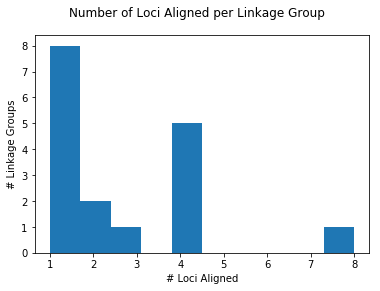

In [19]:
countlist = []
for lg in lg_dict.keys():
    countlist.append(int(lg_dict[lg]))
import matplotlib.pyplot as plt
import numpy as np
plt.hist(countlist)
plt.suptitle("Number of Loci Aligned per Linkage Group")
plt.xlabel("# Loci Aligned")
plt.ylabel("# Linkage Groups")
plt.show()

In [20]:
plt.close()

** Linkage Group 16 has eight outlier loci **

In [21]:
lg_dict["LG16"]

8


<br>
### 5. Annotation

<br>
These notes were taken from Charlie Waters. 

**STEP ONE: BAM to sortedBAM to BED**

In [10]:
!samtools sort batch_8_outliers_bowtie2_Acod_filteredMQ.bam \
-o batch_8_outliers_bowtie2_Acod_filteredMQ_sorted.bam

In [12]:
cd ../bedtools2/bin/

/mnt/hgfs/PCod-Korea-repo/analyses/Outliers/bedtools2/bin


In [13]:
!./bamToBed -i /mnt/hgfs/PCod-Korea-repo/analyses/Outliers/batch8_verif/batch_8_outliers_bowtie2_Acod_filteredMQ_sorted.bam \
>> /mnt/hgfs/PCod-Korea-repo/analyses/Outliers/batch8_verif/batch_8_outliers_bowtie2_Acod_filteredMQ_sorted.bed


<br>
#### STEP TWO: Sort the BED file

In [14]:
!./sortBed -i /mnt/hgfs/PCod-Korea-repo/analyses/Outliers/batch8_verif/batch_8_outliers_bowtie2_Acod_filteredMQ_sorted.bed \
> /mnt/hgfs/PCod-Korea-repo/analyses/Outliers/batch8_verif/batch_8_outliers_bowtie2_Acod_filteredMQ_sorted2.bed

<br>
#### STEP THREE: Download and sort annotation file

First, I downloaded the file [gadMor2_annotation_complete.gff](https://osf.io/g9w7s/).

The file is too big to manually sort, so I grabbed only the rows that have "gene" in them. 

In [ ]:
!grep 'gene' /mnt/hgfs/PCod-Compare-repo/ACod_reference/gadMor2_annotation_complete.gff > \
/mnt/hgfs/PCod-Compare-repo/ACod_reference/gadMor2_annotation_complete_genes.gff

Then I opened the file in excel and sorted first by chromosome (scaffold), and then by start position. New file: 
`gadMor2_annotation_complete_genes_manualsort.gff`

<br>
#### STEP FOUR: run closestBed

DON'T USE BEDTOOLS V2.25 to run the closestBED command.

This must be done from within the `bedtools2/bin` folder. 


`closest -a file.bed -b .gff -g table.tab -D b > outfile.bed`


Argument `-D a`: reports the closest featured in `-b` (ACod) WITH its distance from `-a` as an extra column. Will use negative distances to report upstream features. Reports in respect to `-a`, so "upstream" means that the ACod gene has a higher (start,stop) than the PCod sequence. 

Argument `-k`: report the "k" closest hits. Default is 1

In [24]:
!./closestBed -a ../../batch8_verif/batch_8_outliers_bowtie2_Acod_filteredMQ_sorted2.bed \
-b /mnt/hgfs/PCod-Compare-repo/ACod_reference/gadMor2_annotation_complete_genes_manualsort.gff \
-D a \
-k 2 \
-header \
> ../../batch8_verif/batch_8_outliers_bowtie2_Acod_MQfiltered_Annotations.bed

#### For formatted version, see Results/batch_8_southeast_BAYESCAN_outliers_annotated.xlsx
<br>
<br>
<br>


#### Step 6: Extract gene sequences from annotations.bed file to BLAST 

So when I looked at my annotations.bed file, I noticed that some of the gene IDs are difficult to interpret. For example, this gene ID clearly states a gene function: 

`ID=GAMO_00032736;Name=GAMO_00032736;Alias=augustus_masked-LG08-processed-gene-181.8;Note=Similar to sirt5: NAD-dependent protein deacylase sirtuin-5%2C mitochondrial (Xenopus tropicalis);Dbxref=Gene3D:G3DSA:3.30.1600.10,Gene3D:G3DSA:3.40.50.1220,Hamap:MF_01121,InterPro:IPR003000,InterPro:IPR026590,InterPro:IPR026591,InterPro:IPR027546,InterPro:IPR029035,PANTHER:PTHR11085,PANTHER:PTHR11085:SF13,Pfam:PF02146,ProSiteProfiles:PS50305,SUPERFAMILY:SSF52467;Ontology_term=GO:0036054,GO:0036055,GO:0070403;`


However, this one does not: 

`ID=LG08:hit:131211:4.5.0.181;Name=augustus_masked-LG08-abinit-gene-181.8-mRNA-1;_AED=0.41;_eAED=0.41;_QI=0|0.83|0.71|0.85|1|1|7|0|278`
<br>
<br>

So for each of the outliers that is near a gene that is not obviously identified, I'm going to use `samtools` to extract the full sequence of that gene from the genome fasta file, and then BLAST it online. 

This might be a huge pain, so I'm going to prioritize outliers that also came up in the south v. east comparison. 

The code to do so is: 

`!samtools faidx genome.fa geneA:x-y # returns sequence from positions x through y from geneA`
